In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import interpolate

INPUT = np.array([1, 1]).reshape(-1,1)/np.sqrt(2)
WAVEGUIDE_SIZE = 100
FIGSIZE = (10, 5)

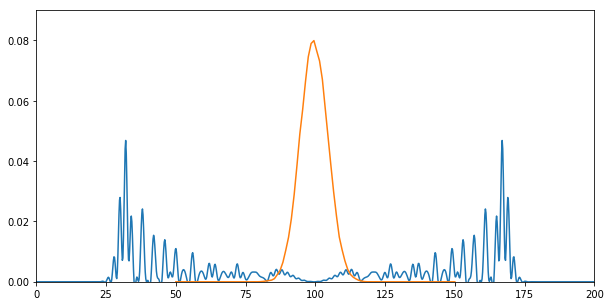

In [71]:
def operator(order=1):
    op = np.zeros((order*2, order*2), complex)
    np.fill_diagonal(op, 1)
    for i in range(order):
        op[2*i][2*i+1] = 1j
        op[2*i+1][2*i] = 1j
    op = op/np.sqrt(2)
    return op

def waveguide_operation(_in):
    op = operator(int(_in.shape[0]/2))
    return np.matmul(op, _in)

def waveguide(step=1):
    _out = waveguide_operation(INPUT)
    heatmap = _out
    for i in range(step-1):
        _in = np.vstack((0, _out, 0))
        _out = waveguide_operation(_in)
        heatmap = np.vstack((np.zeros(heatmap.shape[1]), heatmap, np.zeros(heatmap.shape[1])))
        heatmap = np.hstack((heatmap, np.square(_out)))
    return np.absolute(np.square(_out).real), np.transpose(heatmap.real)

def classical_waveguide(step=1):
    _all_out = np.zeros(step).reshape(-1, 1)
    heatmap = np.zeros(2*step*step).reshape(2*step, step)
    monte_steps = 50000
    for m in range(monte_steps):
        _out = np.array([1]).reshape(-1,1)
        for i in range(step-1):
            _out = np.vstack((_out, 0))
            inx = np.where(_out == 1)
            if np.random.rand() > 0.5:
                _out[inx] = 0
                _out[inx[0][0]+1][inx[1][0]] = 1
            heatmap[int(2*inx[0][0]+step-i)][i] = heatmap[int(2*inx[0][0]+step-i)][i] + 1
            heatmap[int(2*inx[0][0]+step-i+1)][i] = heatmap[int(2*inx[0][0]+step-i+1)][i] + 1
        heatmap[int(2*inx[0][0]+step-i)][-1] = heatmap[int(2*inx[0][0]+step-i)][-1] + 1
        heatmap[int(2*inx[0][0]+step-i+1)][-1] = heatmap[int(2*inx[0][0]+step-i+1)][-1] + 1
        _all_out = np.hstack((_all_out, _out))
    _monte_out = [float(np.count_nonzero(_all_out[i]))/monte_steps for i in range(_all_out.shape[0])]
    return _monte_out, np.transpose(heatmap)/monte_steps

out, heatmap = waveguide(WAVEGUIDE_SIZE)
cl_out, cl_heatmap = classical_waveguide(WAVEGUIDE_SIZE)

plt.figure(figsize=FIGSIZE)
tck1 = interpolate.splrep(range(len(out)), out, s=0)
tck2 = interpolate.splrep(range(int(len(cl_out)/2), int(len(cl_out)+len(cl_out)/2)), cl_out, s=0)
xnew1 = np.linspace(0, len(out), num=1000)
xnew2 = np.linspace(int(len(cl_out)/2), int(len(cl_out)+len(cl_out)/2), num=100)
ynew1 = interpolate.splev(xnew1, tck1, der=0)
ynew2 = interpolate.splev(xnew2, tck2, der=0)
plt.plot(xnew1, ynew1, xnew2, ynew2)
plt.xlim(0, len(out))
plt.ylim(0, np.array(cl_out).max() + 0.01)
plt.show()

In [72]:
std1 = np.multiply(np.square(np.array(range(int(-len(out)/2), int(len(out)/2)))), out)
std2 = np.multiply(np.square(np.array(range(int(-len(cl_out)/2), int(len(cl_out)/2)))), cl_out)
print("Variance\n")
print("Quantum: {}".format(np.std(std1)))
print("Classic: {}".format(np.std(std2)))

Variance

Quantum: 30.646765733381947
Classic: 0.457934920663406


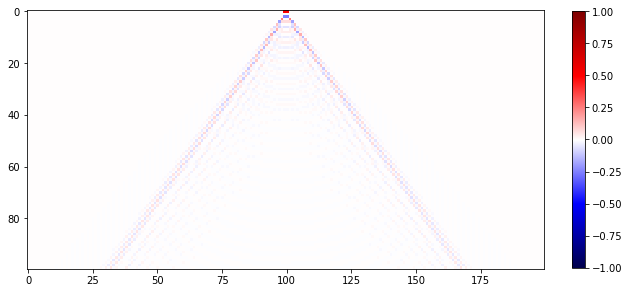

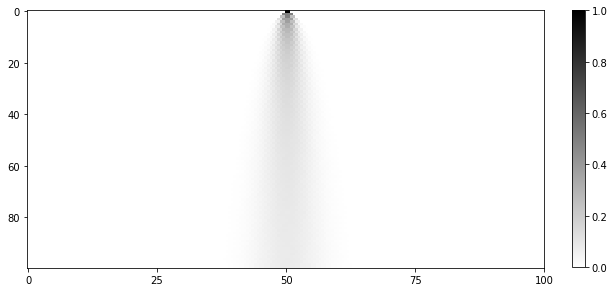

In [88]:
plt.figure(figsize=FIGSIZE)
plt.imshow(heatmap, cmap='seismic',vmin=-1., vmax=1., interpolation='nearest')
plt.colorbar(fraction=0.023)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.imshow(cl_heatmap, cmap='binary',vmin=0., vmax=1., interpolation='nearest')
plt.colorbar(fraction=0.023)
locs, labels = plt.xticks()
labels = [int(elem/2) for elem in locs if int(elem)%2 == 0]
locs = [elem for elem in locs if int(elem)%2 == 0]
plt.xticks(locs, labels)
plt.show()